# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

Note:
- Majority of time spent during experimentation right now is spent on building the forest. Meanwhile the queries are actually pretty fast.

In [2]:
import time
import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pytest

from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
from shared.utils import recall, chamfer
from shared.plotting import plot, plot_similarity_heatmap

sys.path.append(os.path.abspath("../src"))

# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert chamfer(A, B) == pytest.approx(1.0)
assert chamfer(B, A) == pytest.approx(1 + np.sqrt(.5))
assert chamfer(B, C) == pytest.approx(2)
assert chamfer(B, B) == pytest.approx(2)
assert chamfer(C, C) == pytest.approx(4)

C:\Users\keemi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\beir\datasets\data_loader.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Hyperparameters and constants
n = 10                                # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 15                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)

# Get normalized document and query vectors
data = rng.normal(size=(n, m, d)).astype(np.float32)
data /= np.linalg.norm(data, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

distance = lambda a, b: -np.dot(a, b)


In [4]:
# Constructors for each forest type

def build_simple_lsh(l, k, km):
        single_doc_forests = [LSHForest(RandomHyperplaneLSH(d), l, k, km) for _ in range(n)]
        for doc, forest in enumerate(single_doc_forests):
                forest.batch_insert(data[doc])
        return single_doc_forests


def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(RandomHyperplaneLSH(d), l, k, km)
        multi_doc_forest.batch_insert(data)
        return multi_doc_forest

In [5]:
# Retrieval Logic

def collect_matches(forests, a):

        matches = np.empty((n, q, d), dtype=np.float32)
        multi = not isinstance(forests, list)
        if multi:
                for i, query in enumerate(queries):
                        results = forests.query(query, a, dist=distance)
                        for document, result in enumerate(results):
                                idx, _ = result[0]
                                matches[document, i] = forests.data[document][idx]
        else:
                for document, forest in enumerate(forests):
                        for i, query in enumerate(queries):
                                idx = forest.query(query, a, dist=distance)[0][0]
                                matches[document, i] = forest.data[idx] 

        return matches

        

def sim_scores(matches: np.ndarray, queries: np.ndarray) -> np.ndarray:
    """
    Dot-product similarity for every document.
    Returns (D,) vector of scores.
    """
    return np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        
def rank_documents(forests, a) -> list[(int, float)]:
        scores = sim_scores(collect_matches(forests, a), queries)
        order  = np.argsort(-scores)
        return order

def best_document(forests, a) -> tuple[float, int]:
    """
    Convenience wrapper that returns only the best matching document.
    """
    scores = sim_scores(collect_matches(forests, a), queries)
    best   = int(np.argmax(scores))
    return float(scores[best]), best

In [6]:
# Baseline

sims = np.array([chamfer(queries, doc_vecs) for doc_vecs in data], dtype=np.float32)
best_doc = int(np.argmax(sims))
best_score = float(sims[best_doc])
print(best_doc, best_score)

true_ranking = np.argsort(-sims)
print(true_ranking[:10])


4 14.170031547546387
[4 6 2 7 0 5 8 3 1 9]


In [7]:
# Experiment logic

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}

defaults = dict(l=l, k=k, km=km, a=a)

def nearest_experiment(variable, values, defaults, build):
        sims, docs = [], []
        start_total = time.perf_counter()
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                start = time.perf_counter()
                forest = build(parameters['l'], parameters['k'], parameters['km'],)
                sim, doc = best_document(forest, parameters['a'])
                end = time.perf_counter()
                sims.append(sim)
                docs.append(doc)
                print(f"{variable}={value} completed in {end - start:.4f} seconds.")
        end_total = time.perf_counter()
        print(f"\nFinished experiment with varying {variable} in {end_total - start_total:.4f} seconds.")
        return sims, docs
    
def recall_experiment(variable, values, defaults, build, num_items):
        recall_vals = []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(parameters['l'], parameters['k'], parameters['km'],)
                ranking = rank_documents(forest, parameters['a'])
                recall_vals.append(recall(true_ranking, ranking, num_items))
        print(f"Finished recall experiment: {variable}")
        return recall_vals
     
    



l=1 completed in 0.2491 seconds.
l=4 completed in 0.7435 seconds.
l=8 completed in 1.4532 seconds.
l=16 completed in 2.7577 seconds.
l=32 completed in 5.2148 seconds.

Finished experiment with varying l in 10.4190 seconds.


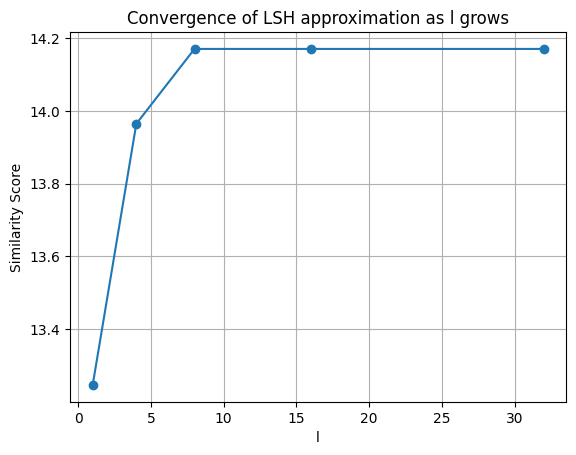

Best l = 8 → doc #4


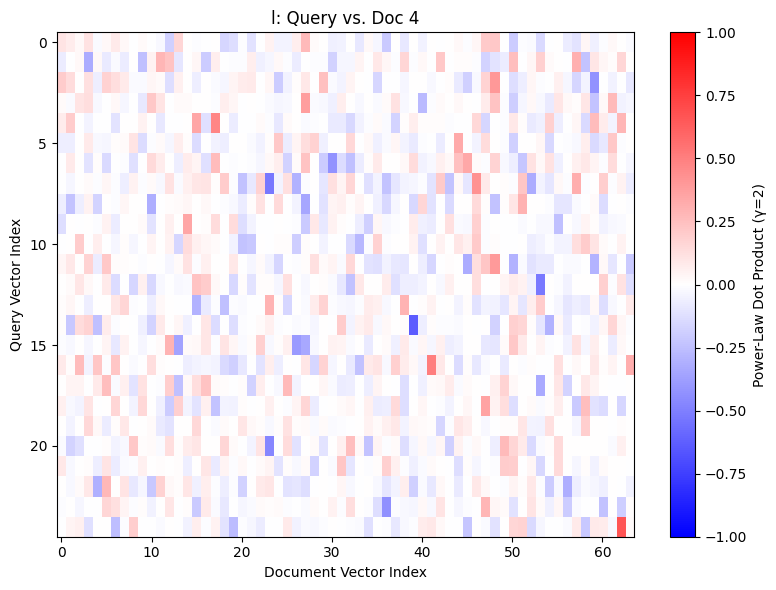

k=4 completed in 2.6874 seconds.
k=8 completed in 1.6208 seconds.
k=16 completed in 1.8210 seconds.


KeyboardInterrupt: 

In [8]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = nearest_experiment(var, vals, defaults, build_simple_lsh)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, data[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")


l=1 completed in 0.1302 seconds.
l=4 completed in 1.1175 seconds.
l=8 completed in 1.8446 seconds.
l=16 completed in 3.0507 seconds.
l=32 completed in 6.8366 seconds.

Finished experiment with varying l in 12.9805 seconds.
k=4 completed in 1.3058 seconds.
k=8 completed in 3.3028 seconds.
k=16 completed in 2.0295 seconds.
k=32 completed in 1.7284 seconds.
k=64 completed in 2.2645 seconds.

Finished experiment with varying k in 10.6318 seconds.
km=16 completed in 0.3065 seconds.
km=32 completed in 1.4277 seconds.
km=64 completed in 2.1047 seconds.
km=128 completed in 4.0157 seconds.
km=256 completed in 8.1362 seconds.

Finished experiment with varying km in 15.9915 seconds.
a=1 completed in 1.2662 seconds.
a=4 completed in 3.3431 seconds.
a=8 completed in 1.9902 seconds.
a=16 completed in 2.2521 seconds.
a=32 completed in 2.0541 seconds.

Finished experiment with varying a in 10.9070 seconds.


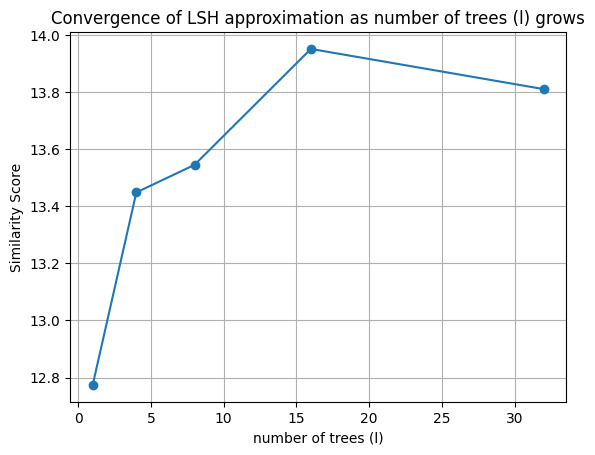

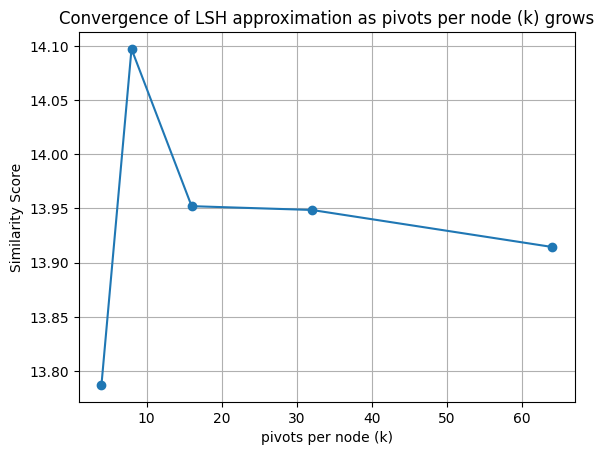

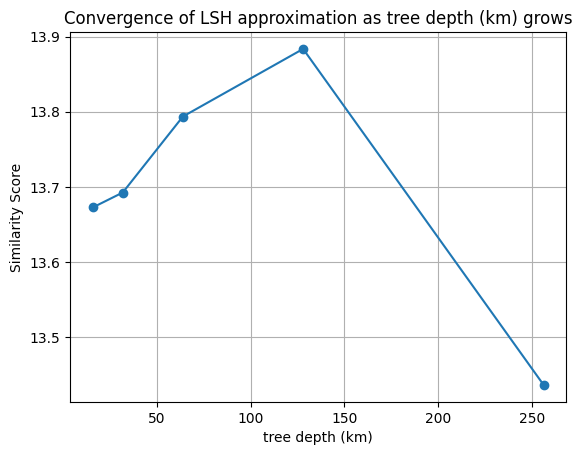

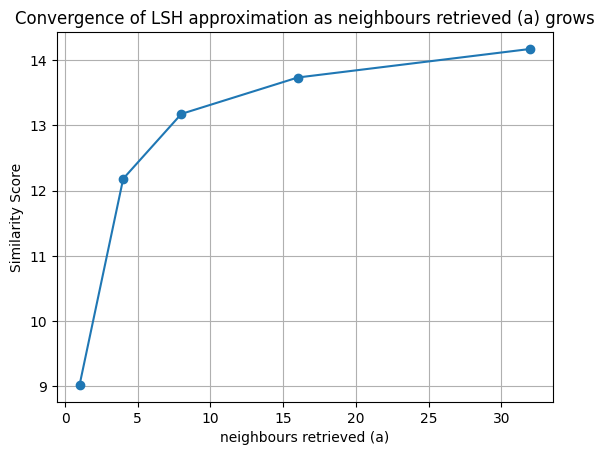

In [ ]:

# Evaluate multi-doc
results = {var: nearest_experiment(var, vals, defaults, build_multidoc_lsh) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')


Finished recall experiment: l
Finished recall experiment: k
Finished recall experiment: km
Finished recall experiment: a


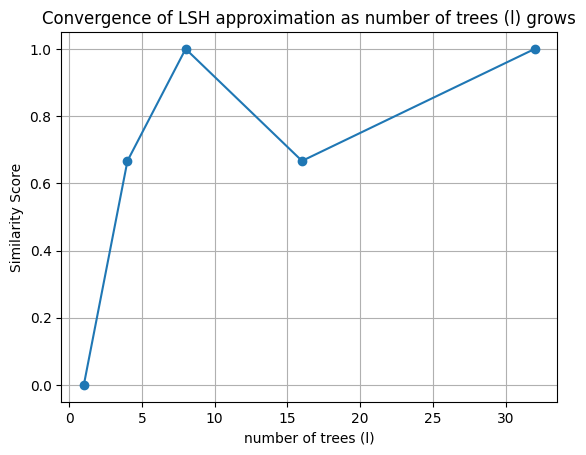

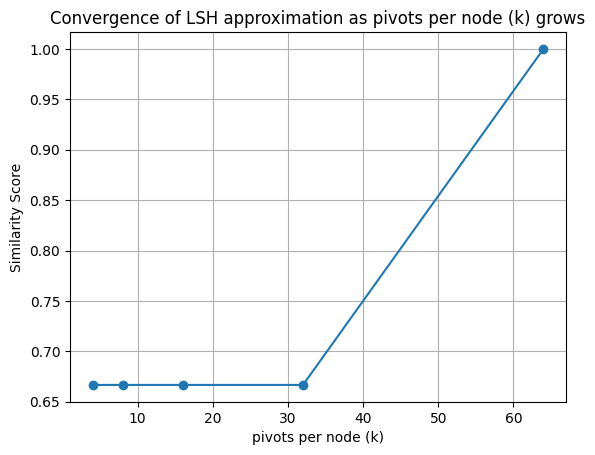

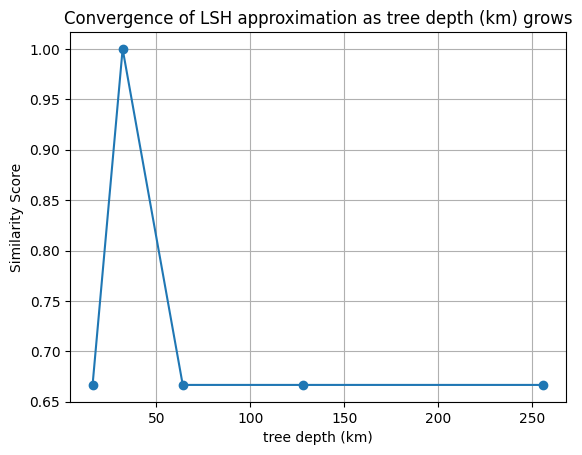

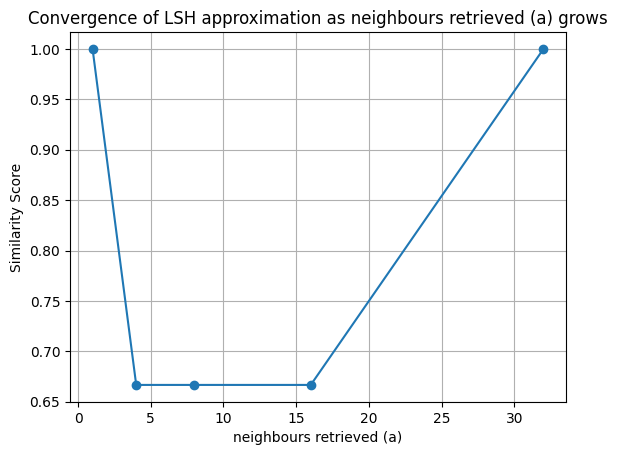

In [9]:
# Evaluate multi-doc recall
results = {var: recall_experiment(var, vals, defaults, build_multidoc_lsh, 3) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'],  'number of trees (l)')
plot(experiments['k'],  results['k'],  'pivots per node (k)')
plot(experiments['km'], results['km'], 'tree depth (km)')
plot(experiments['a'],  results['a'],  'neighbours retrieved (a)')